# A1

In [54]:
# Standard imports
import numpy as np
import math
import matplotlib.pylab as plt
%matplotlib inline
from scipy import integrate

## Some supplied helper functions

In [55]:
def PlotSpikeRaster(st, y_range=[0, 1.]):
    '''
    PlotSpikeRaster(spiketimes, y_range=[0, 1.])

    Plots a spike raster plot for a list of arrays of spike times.

    Input:
      spiketimes is a list of arrays of spike times, like that returned
          by the function Stim2Spikes.
      y_range is a 2-tuple that holds the y-values that the raster ticks
          should be drawn between
    '''
    N = len(st)  # number of neurons

    #levels = np.linspace(y_range[0], y_range[1], N+1, endpoint=True)
    levels = np.linspace(y_range[1], y_range[0], N+1, endpoint=True)
    for n in range(N):
        nspikes = len(st[n])
        #y = [ [levels[n]]*nspikes , [levels[n+1]]*nspikes ]
        y = [ [levels[n+1]]*nspikes , [levels[n]]*nspikes ]
        #y = y_range[0] + [levels[n]]*nspikes
        plt.plot(np.vstack((st[n],st[n])), y, color=np.random.rand(3))
    plt.ylim(y_range)
    plt.xlabel('Time (s)')
    return


def GenerateSpikeTrain(rates, T, jitter=0.):
    '''
    spike_times = GenerateSpikeTrain(rates, T)
    
    Creates a spike train (as an array of time stamps).
    
    Input:
    rates is an array or list of firing rates (in Hz), one
        firing rate for each interval.
    T is an array or list (the same size as 'rates') that gives
        the time to end each interval
    jitter is a scalar that determines how much the spikes
        are randomly moved
        
    Output:
    spike_times is an array of times when spikes occurred
    
    Example: To create a spike train of 10Hz for 0.5s, followed
             by 25Hz that starts at 0.5s and ends at 2s, use
             
               GenerateSpikeTrain([10, 25], [0.5, 2])
    '''
    s = []
    t = 0.
    for idx in range(0,len(rates)):
        Trange = T[idx] - t
        if rates[idx]!=0:
            delta = 1. / rates[idx]
            N = rates[idx] * Trange
            times = np.arange(t+delta/2., T[idx], delta)
            times += np.random.normal(scale=delta*jitter, size=np.shape(times))
            s.extend(times)
        t = T[idx]
    s.sort()
    return np.array(s)


class InputNeuron(object):
    
    def __init__(self, spiketrain):
        '''
        InputNeuron(spiketrain)
        
        Constructor for InputNeuron class.
        
        InputNeuron is a class of neuron that can be used to inject spikes into
        the network. When involved in a simulation, an InputNeuron will generate
        spikes at the times specified during its construction.
        
        Inputs:
         spiketrain is an array or list of spike times
        '''
        self.spikes = np.array(spiketrain)

    def SpikesBetween(self, t_start, t_end):
        '''
        numspikes = InputNeuron.SpikesBetween(t_start, t_end)
        
        Returns the number of times the neuron spiked between t_start and t_end.
        Specifically, it counts a spike if it occurred at t, where
        t_start <= t < t_end
        '''
        sp_bool = np.logical_and( np.array(self.spikes)>=t_start, np.array(self.spikes)<t_end )
        return np.sum(sp_bool)
    
    def Slope(self):
        return
    
    def Step(self, t, dt):
        return

# Q1: LIFNeuron Class

## LIFNeuron class

In [56]:
class LIFNeuron(object):

    def __init__(self, tau_m=0.02, tau_ref=0.002, tau_s=0.05):
        '''
        LIFNeuron(tau_m=0.02, tau_ref=0.002, tau_s=0.05)
        
        Constructor for LIFNeuron class
        
        Inputs:
         tau_m   membrane time constant, in seconds (s)
         tau_ref refractory period (s)
         tau_s   synaptic time constant (s)
        '''
        self.tau_m = tau_m      # membrane time constant
        self.tau_ref = tau_ref  # refractory period
        self.tau_s = tau_s      # synaptic time constant
        self.v = 0.             # sub-threshold membrane potential (voltage)
        self.s = 0.             # post-synaptic current (PSC)
        self.dvdt = 0.          # slope of v (w.r.t. time)
        self.dsdt = 0.          # slope of s (w.r.t. time)
        
        self.weighted_incoming_spikes = 0.  # weighted sum of incoming spikes (for one time step)
        self.ref_remaining = 0. # amount of time remaining in the refractory period
        
        # For plotting
        self.v_history = []     # records v over time
        self.spikes = []        # list of times when this neuron spiked
        

    def SpikesBetween(self, t_start, t_end):
        '''
        numspikes = LIFNeuron.SpikesBetween(t_start, t_end)
        
        Returns the number of times the neuron spiked between t_start and t_end.
        Specifically, it counts a spike if it occurred at t, where
        t_start <= t < t_end
        '''
        sp_bool = np.logical_and( np.array(self.spikes)>=t_start, np.array(self.spikes)<t_end )
        return np.sum(sp_bool)
    
    
    def Slope(self):
        '''
        LIFNeuron.Slope()
        
        Evaluates the right-hand side of the differential equations that
        govern v and s. The slopes get stored in the internal variables
          self.dvdt, and
          self.dsdt
        '''
        self.dvdt = (self.s - self.v)/self.tau_m
        self.dsdt = -self.s / self.tau_s
        
        
    def Step(self, t, dt):
        '''
        LIFNeuron.Step(t, dt)
        
        Updates the LIF neuron state by taking an Euler step in v and s.
        If v reaches the threshold of 1, the neuron fires an action potential
        (spike). The spike time is appended to the list self.spikes, and v
        is set to zero. After a spike, the neuron is dormant for self.tau_ref
        seconds.
        
        If a spike occurs part-way through a time step, inear interpolation
        is used to estimate the time that v hit the threshold of 1.
        '''
        
        # Check wether neuron is dormant, adjust the times correspondingly
        if self.ref_remaining > 0.0:
            self.ref_remaining = max(0.0, self.ref_remaining - dt)
            v=0.0
            self.s = self.s + dt*self.dsdt
        else:
            self.s = self.s + dt*self.dsdt
            v = self.v + dt*self.dvdt

            if v >= 1.0:
                # Neuron fired an action potential
                # Perform linear interpolation
                interpolated_t = np.interp(1.0, [self.v, v], [t, t+dt])
                self.spikes.append(interpolated_t)
                v = 1.0
                self.ref_remaining = (self.tau_ref - (t+dt-interpolated_t))
    
        self.s += self.weighted_incoming_spikes/self.tau_s
        self.v = v
            
        # Store v (for plotting), and reset incoming spike accumulator
        self.v_history.append(self.v)
        self.weighted_incoming_spikes = 0.
        
        if self.v >= 1:
            self.v = 0.0
            
        
    def ReceiveSpike(self, w):
        '''
        LIFNeuron.ReceiveSpike(w)
        
        Registers the arrival of a spike from a presynaptic neuron. The
        member variable self.weighted_incoming_spikes keeps track of all
        the incoming spikes, each weighted by their respective connection
        weights. It is sufficient to add them all together to tabulate the
        total incoming weighted spikes (from all presynaptic neurons).
        
        Input:
         w    is the connection weight from the presynaptic neuron.
        '''
        self.weighted_incoming_spikes += w  # [1]
        

# Q2: SpikingNetwork Class

## SpikingNetwork Class

In [57]:
class SpikingNetwork(object):
    
    def __init__(self):
        '''
        SpikingNetwork()
        
        Constructor for SpikingNetwork class.
        
        The SpikingNetwork class contains a collection of neurons,
        and the connections between those neurons.
        '''
        self.neurons = []      # List of neurons (of various kinds)
        self.connections = []  # List of connections
        self.t_history = []    # List of time stamps for the Euler steps
                               # (Useful for plotting)
        
        
    def AddNeuron(self, neur):
        '''
        SpikingNetwork.AddNeuron(neuron)
        
        Adds a neuron to the network.
        
        Input:
         neuron is an object of type LIFNeuron or InputNeuron
        '''
        self.neurons.append(neur)

        
    def Connect(self, pre, post, w):
        '''
        SpikingNetwork.Connect(pre, post, w)
        
        Connects neuron 'pre' to neuron 'post' with a connection
        weigth of w.
        
        Each "connection" is a list of 3 numbers of the form:
         [ pre_idx, post_idx, weight ]
        where
         pre_idx is the list index of the pre-synaptic neuron,
         post_idx is the list index of the post-synaptic neuron, and
         weight is the connection weight.
        eg. self.connections = [[0,1,0.05], [1,2,0.04], [1,0,-0.2]]
        '''
        self.connections.append([pre, post, w])
     
    
    def Simulate(self, T, dt=0.001):
        '''
        SpikingNetwork.Simulate(T, dt=0.001)
        
        Simulates the network for T seconds by taking Euler steps
        of size dt.
        
        Inputs:
         T    how long to integrate for
         dt   time step for Euler's method
        '''
        # This code takes care of recording time samples in a way
        # that allows continuation. You needn't fuss over this code.
        current = 0 if len(self.t_history)==0 else self.t_history[-1]
        t_segment = np.arange(current, current+T, dt)
        
        spike_delivery = {}
        next_spike_delivery = {}
        
    
        # Loop over time steps (I've set that up for you)
        for tt in t_segment:
            self.t_history.append(tt)  # Record timestep
            
            for i in range(len(self.neurons)):
                
                # First deliver all the spikes from the last timestep to this neuron
                if i in spike_delivery:
                    for spike_weight in spike_delivery[i]:
                        self.neurons[i].ReceiveSpike(spike_weight)
    
                # Remove from spike_delivery
                if i in spike_delivery:
                    spike_delivery.pop(i)
                    
                # Call Slope
                self.neurons[i].Slope()
                
                # Call Step on Neuron
                self.neurons[i].Step(tt, dt)
                
                # for each neuron, check for spike
                if self.neurons[i].SpikesBetween(tt, tt+dt):
                    for pre, post, weight in filter(lambda x: x[0] == i, self.connections):
                        if post not in next_spike_delivery:
                            next_spike_delivery[post] = []
                        next_spike_delivery[post].append(weight)
                        
            # Swap for the 2 timesteps
            spike_delivery, next_spike_delivery = next_spike_delivery, {}


        
        
    def AllSpikeTimes(self):
        '''
        SpikingNetwork.AllSpikeTimes()
        
        Returns all the spikes of all the neurons in the network.
        Useful for making spike-raster plots of network activity.
        
        Output:
         all_spikes  a list of sublists, where each sublist holds
                     the spike times of one of the neurons
        '''
        blah = []
        for neur in self.neurons:
            blah.append(np.array(neur.spikes))
        return blah

# Q3: Experiments with Spiking Networks

## (a) One LIF Neuron

In [58]:
net = SpikingNetwork()
net.AddNeuron(LIFNeuron(tau_s=0.1))  # Neuron 0
net.AddNeuron(InputNeuron( GenerateSpikeTrain([30], [1]) ))  # Neuron 1
net.Connect(1, 0, 0.05)  # Connect from neuron 1 to neuron 0
net.Simulate(1, 0.001)

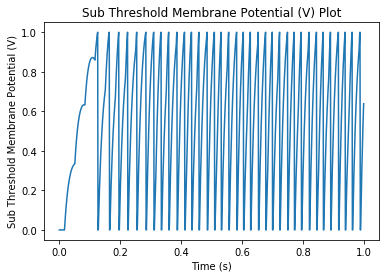

In [59]:
# i.
plt.figure()
plt.title("Sub Threshold Membrane Potential (V) Plot")
plt.xlabel("Time (s)")
plt.ylabel("Sub Threshold Membrane Potential (V)")
plt.plot(net.t_history, net.neurons[0].v_history)


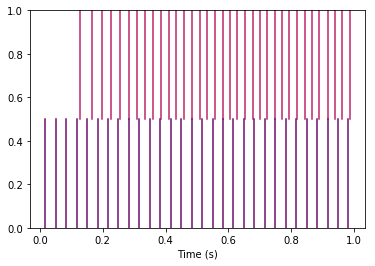

In [60]:
# ii.
PlotSpikeRaster(net.AllSpikeTimes())

## (b) LIF Firing Rate Curve

In [61]:
# i.
net = SpikingNetwork()
net.AddNeuron(LIFNeuron(tau_s=0.1))  # Neuron 0

input_firing_rate = [i for i in range(5,101,5)]
input_firing_time = [2*i for i in range(1,len(input_firing_rate)+1)]
net.AddNeuron(InputNeuron( GenerateSpikeTrain(input_firing_rate, input_firing_time) ))  # Neuron 1
net.Connect(1, 0, 0.03)  # Connect from neuron 1 to neuron 0
net.Simulate(len(input_firing_time)*2, 0.001)

In [62]:
# ii.
# For each 2 second interval, compute how many spikes occurred
output_spikes = []
for t in range(len(input_firing_time)):
    start = 0 if t==0 else input_firing_time[t-1]
    end = input_firing_time[t]
    output_spikes.append(net.neurons[0].SpikesBetween(start, end))
    
print(output_spikes)

[0, 0, 0, 0, 0, 0, 30, 52, 72, 85, 96, 109, 122, 133, 144, 153, 166, 178, 182, 197]


Text(0, 0.5, 'LIF Firing Rate (Hz)')

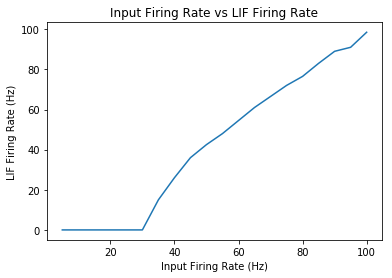

In [63]:
# iii.
output_firing_rate = [ns/2 for ns in output_spikes]
plt.figure()
plt.plot(input_firing_rate, output_firing_rate)
plt.title("Input Firing Rate vs LIF Firing Rate")
plt.xlabel("Input Firing Rate (Hz)")
plt.ylabel("LIF Firing Rate (Hz)")

## (c) Two LIF Neurons

In [64]:
# i.
net = SpikingNetwork()
net.AddNeuron(LIFNeuron(tau_s=0.05)) # Neuron 0
net.AddNeuron(LIFNeuron(tau_s=0.05)) # Neuron 1

net.AddNeuron(InputNeuron( GenerateSpikeTrain([30, 0], [0.3,0]) )) # Neuron 2
connections = [(2,0,0.05),(0, 1, 0.05), (1,0, 0.05)]
for conn in connections:
    net.Connect(*conn)
    
net.Simulate(1, 0.001)

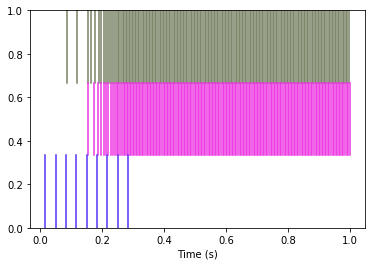

In [65]:
# ii.
# Spike Raster Plot for the 3 neurons
PlotSpikeRaster(net.AllSpikeTimes())

## (d) Three LIF Neurons: Inhibition

In [66]:
# i.
net = SpikingNetwork()
net.AddNeuron(LIFNeuron(tau_s=0.05)) # Neuron 0
net.AddNeuron(LIFNeuron(tau_s=0.05)) # Neuron 1
net.AddNeuron(LIFNeuron(tau_s=0.05)) # Neuron 2


net.AddNeuron(InputNeuron( GenerateSpikeTrain([30, 0], [0.3,1]) )) # Neuron 3
net.AddNeuron(InputNeuron( GenerateSpikeTrain([0, 50], [0.7,1]) )) # Neuron 4
connections = [(3,0,0.05),(0, 1, 0.05), (1,0, 0.05), (2, 1, -0.2), (4, 2, 0.05)]
for conn in connections:
    net.Connect(*conn)

net.Simulate(1.5, 0.001)

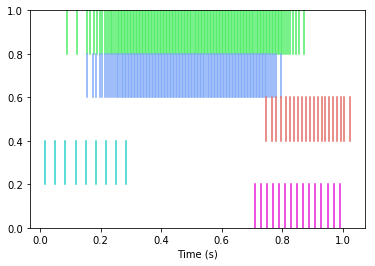

In [67]:
# ii.
PlotSpikeRaster(net.AllSpikeTimes())

### iii.

On comparing the spike raster plots generated in 3(c) and 3(d), we notice that in the case of 3(c), the spiking activity of neurons LIF A and LIF B continues at the same rate (till the end of simulation) since LIF A and LIF B are mutually recursive and enforce each other with positive connection weights. However when we add an inhibitor connection in 3(d), we notice that soon after the Input Neuron to LIF C starts firing (0.7 s), LIF C shows spiking activity and due to the negative connection weight to from LIF C to LIF B, LIF B receives a decrease in incoming potential due to which it soon stops reaching its action potential and stops showing firing activity (~0.8s). The reduction in input current (or potential) is then propagated to LIF A and it eventually dies out (~0.9s).
An important point to note is that first LIF B stops showing spiking activity, since it is connected to LIF C with a negative weight. However, it doesn't stop suddenly but there is a reduction in the spiking rate, as it still continues to receive the current from LIF A. However because of the recursive nature, this current dies out, and evenutally LIF A stops showing spiking activity. 

## (e) Ring Oscillator

In [68]:
# i.
# Create excitatory ring
net = SpikingNetwork()
connections = []
for i in range(8):
    net.AddNeuron(LIFNeuron(tau_s=0.1, tau_m=0.05))
    net.Connect(i, (i+1)%8, 0.2)
    

In [69]:
# ii.
# Create inhibitor ring
for i in range(8):
    net.Connect(i, (i-1)%8, -0.4)

In [70]:
# iii.
# Input Neuron
net.AddNeuron(InputNeuron( GenerateSpikeTrain([25], [0.3]) )) # Neuron at index 8
net.Connect(8,0,0.2)

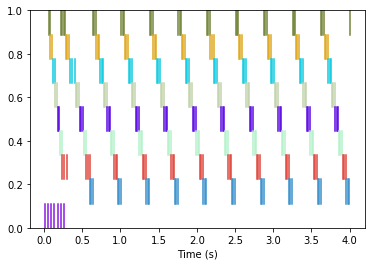

In [71]:
# iv.
net.Simulate(4, 0.001)
PlotSpikeRaster(net.AllSpikeTimes())

# Q4: Neural Activation Functions

## (a) ReLU derivative

Let f(x) = Relu(x) and f'(x) be its derivate  
if x < 0: f'(x) = 0  
if x > 0: f'(x) = 1  
if x == 0 : f'(x) = Undefined  

## (b.i) Logistic

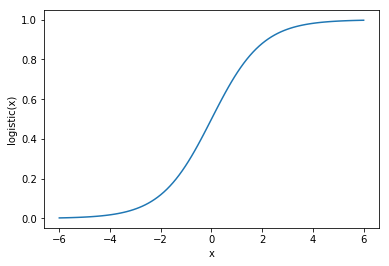

In [72]:
# i.
def logistic(x):
    return 1/(1 + math.exp(-x))

numbers = np.linspace(-6, 6, 100)
values = [logistic(x) for x in numbers]
plt.figure()
plt.xlabel("x")
plt.ylabel("logistic(x)")
plt.plot(numbers, values)

Gradient approaches zero at -6, 6  
Gradient is maximum at 0

## (b.ii) tanh

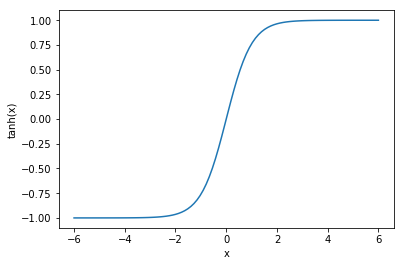

In [73]:
# ii.
numbers = np.linspace(-6, 6, 100)
values = [math.tanh(x) for x in numbers]
plt.figure()
plt.xlabel("x")
plt.ylabel("tanh(x)")
plt.plot(numbers, values)

Gradient appraoches zero at -6, 6  
Gradient is mazimum at 0  

## (b.iii) ReLU

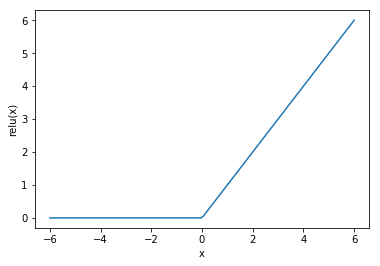

In [74]:
# iii.
def relu(x):
    return 0 if x <= 0 else x

numbers = np.linspace(-6, 6, 150)
values = [relu(x) for x in numbers]
plt.figure()
plt.xlabel("x")
plt.ylabel("relu(x)")
plt.plot(numbers, values)

Gradient is maximum (=1) for x > 0  
Gradient is 0 for x < 0

## (c.i) Derivative of f with respect to x

$$
f'(wx+b)*w
$$

## (c.ii) Derivative of f with respect to W

$$
f'(wx+b)*x
$$

## (c.ii) Derivative of f with respect to b

$$
f'(wx+b)
$$